# Toronto house prediction model

## Data cleaning and re-factoring

In [447]:
import pandas as pd
import os
from os.path import curdir
import numpy as np
from statsmodels.formula.api import ols

path = os.path.join(curdir,'Data',"house.csv")
data = pd.read_csv(path, delimiter = ',')

type_dict = {'Condo Townhouse': 5, 'Condo Apt': 4, 'Detached': 7, 'Comm Element Condo': 3, 'Att/Row/Twnhouse': 5, 'Semi-Detached': 6, 'Co-Op Apt': 2, 'Co-Ownership Apt': 1}
def replace_house_type_to_int(type):
    if type in type_dict:
        return type_dict[type]
    return -1

data['type'] = data['type'].map(replace_house_type_to_int)
data = data[data['type'] != -1]
data = data.dropna()

print("Shape of data before outlier removal is: ", data.shape)
for col in data.columns:
    Q3 = np.quantile(data[col], 0.71)
    Q1 = np.quantile(data[col], 0.3)
    IQR = Q3 - Q1
 
    print("IQR value for column %s is: %s" % (col, IQR))
    global outlier_free_list
    global filtered_data
 
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    data = data[data[col] >= lower_range]
    data = data[data[col] <= upper_range]
print("Shape of data after outlier removal is: ", data.shape)
data.head()


Shape of data before outlier removal is:  (10673, 13)
IQR value for column final_price is: 260000.0
IQR value for column list_price is: 199100.0
IQR value for column bedrooms is: 1.0
IQR value for column Dens is: 1.0
IQR value for column bathrooms is: 1.0
IQR value for column size is: 450.0
IQR value for column parking is: 0.0
IQR value for column type is: 0.0
IQR value for column latitude is: 0.11238879999999796
IQR value for column longitude is: 0.06713057999999705
IQR value for column mean_district_income is: 22431.0
IQR value for column district_code is: 30.0
IQR value for column School_min_dist_km is: 0.275679712
Shape of data after outlier removal is:  (3775, 13)


,final_price,list_price,bedrooms,Dens,bathrooms,size,parking,type,latitude,longitude,mean_district_income,district_code,School_min_dist_km
320,485000,499900,2,0,2,1100,1,4,43.685460,-79.519374,45615,8,0.405672
321,482000,489900,3,0,2,1300,1,4,43.686315,-79.514191,45615,8,0.539151
322,525000,549900,2,0,2,1300,1,4,43.685143,-79.515948,45615,8,0.532392
324,585000,599000,2,1,2,950,1,4,43.683005,-79.525699,45615,8,0.834382
325,595000,599900,2,1,2,950,1,4,43.683005,-79.525699,45615,8,0.834382


In [448]:
str = 'final_price ~ bathrooms + Dens + size + parking  + type + mean_district_income + School_min_dist_km'
model = ols(str,data[0: int(len(data) * 0.7)]).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            final_price   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     532.6
Date:                Wed, 12 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:40:40   Log-Likelihood:                -34257.
No. Observations:                2642   AIC:                         6.853e+04
Df Residuals:                    2636   BIC:                         6.856e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             3102.3056 

In [449]:
X = data.drop(columns=['final_price', 'list_price', 'bedrooms','district_code', 'longitude', 'latitude' ]).values
y = data['final_price'].values

In [450]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

X_train, X_test, y_train, y_test = train_test_split(
    X,y,train_size=0.7,random_state=0)
reg = Lasso().fit(X_train, y_train)

### Random input Test

In [451]:

new_needs = {'bathrooms':[2] ,
            'Dens':[1],'size':[800], 'parking':[1],'type':[3],'mean_district_income':[31771], 'School_min_dist_km':[1]}
newneeds = pd.DataFrame(new_needs)
print(reg.predict(newneeds))

[433173.71045637]


c:\Users\yuhen\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


## Plotting Regression Models 

### Residual vs Fitted Values

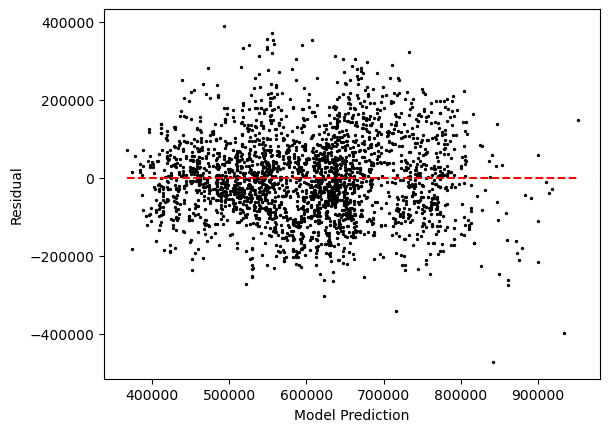

In [452]:
#Residuals calculated by definition above.
predicted_y = reg.predict(X_train)
#Note we can perform element-wise subtraction between arrays like so
residuals = y_train - predicted_y

import matplotlib.pyplot as plt
plt.scatter(predicted_y,residuals,s=2,c='black')
#This line adds the dashed horizontal line
plt.hlines(0,min(predicted_y),max(predicted_y),color='red',linestyles='dashed')

plt.xlabel("Model Prediction")
plt.ylabel("Residual")
plt.show()

In [453]:
print('Mean of Residuals:',residuals.mean())

Mean of Residuals: -2.2560425728762538e-11


### Normal Q-Q

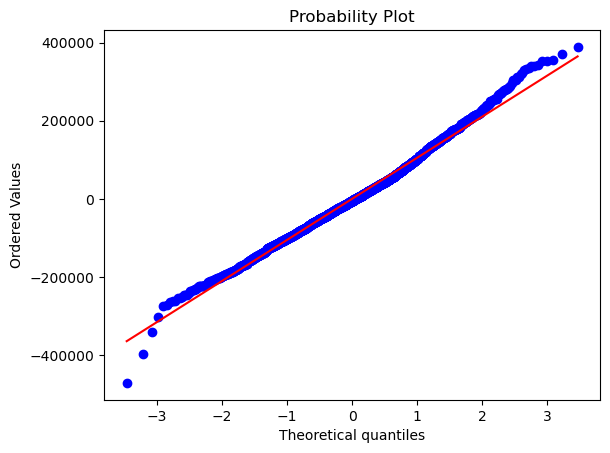

In [454]:
import scipy.stats as stats


fig = plt.figure()
ax = fig.add_subplot(111)

stats.probplot(residuals,dist='norm',plot=ax)
plt.show()

### Scale-Location

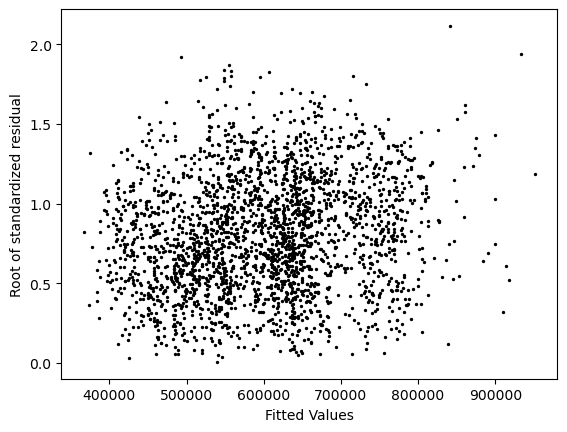

In [455]:
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler().fit(residuals.reshape(-1,1))
norm_residuals = scaler.transform(residuals.reshape(-1,1))

plt.scatter(predicted_y,np.sqrt(np.abs(norm_residuals)),c='black',s=2)
plt.xlabel("Fitted Values")
plt.ylabel("Root of standardized residual")
plt.show()

### Density Plot

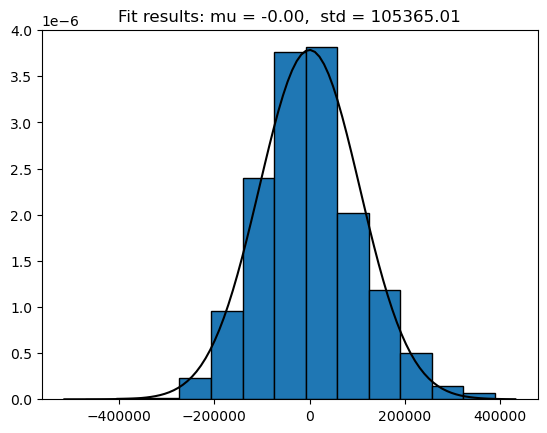

In [456]:
from scipy.stats import norm

# Fit a normal distribution to the data:
mean, std = norm.fit(residuals)

# Plot the histogram.
plt.hist(residuals, bins=13, edgecolor='black', density=True)

# Generate a PDF based on the fitted distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p, color='black')
title = "Fit results: mu = %.2f,  std = %.2f" % (mean, std)
plt.title(title)

plt.show()

### Residual vs Fitted Values

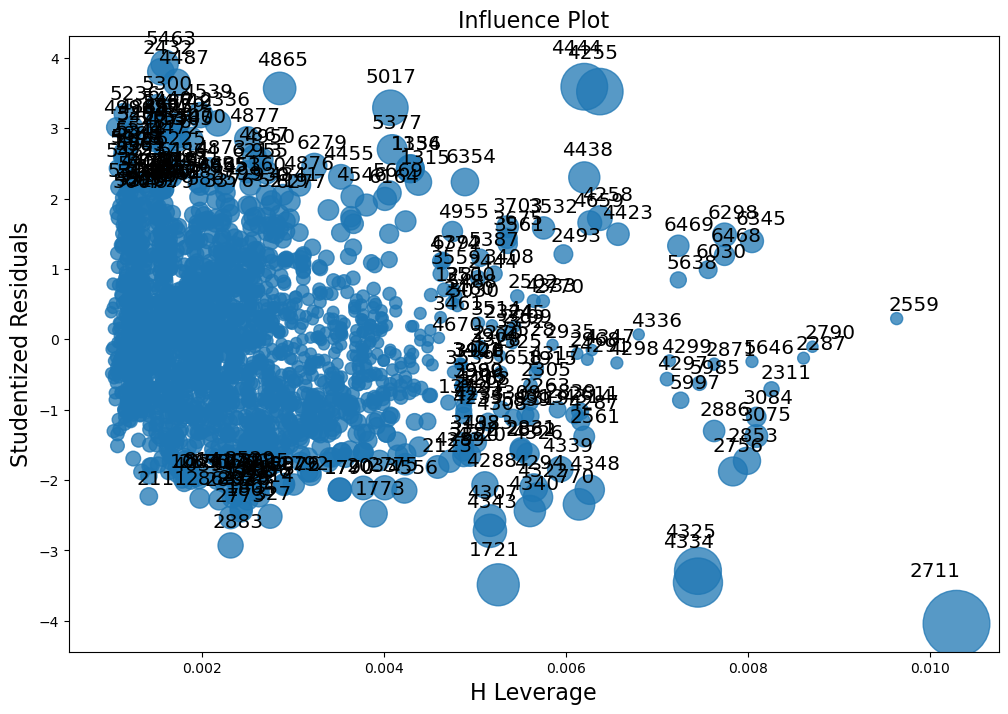

In [457]:
#In a similar fashion to how the QQ plot was built, this plot can be generated.
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(model, ax=ax, criterion="cooks")
plt.show()

## Calculate Statistics

In [458]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from numpy import sqrt

### Train Data

In [459]:
print("R^2:",reg.score(X_train,y_train))
print("Root Mean Squared Error:",sqrt(
    mean_squared_error(y_train,reg.predict(X_train))))
print("Mean Absolute Error:",mean_absolute_error(
    y_train,reg.predict(X_train)))

R^2: 0.4924318867230786
Root Mean Squared Error: 105365.00860431747
Mean Absolute Error: 82174.83385410663


### Test Data 

In [460]:
print("R^2:",reg.score(X_test,y_test))
print("Root Mean Squared Error:",sqrt(
    mean_squared_error(y_test,reg.predict(X_test))))
print("Mean Absolute Error:",mean_absolute_error(
    y_test,reg.predict(X_test)))

R^2: 0.4624697039720077
Root Mean Squared Error: 106618.70972230705
Mean Absolute Error: 81774.2581138539
